# UNSUPERVISED SENTIMENT ANALYSIS ON IMDB MOVIE DATASET #

We will be performing an unsupervised sentiment analysis using vector similarity and then comparing it against a supervised model accuracy. 
This notebook's vector models are derived from Ahmad Hashemi's medium article.
To get a more intuition on the process, I laid out the steps in forms of vector operations.

**References:**

[Unsupervised Semantic Sentiment Analysis of IMDB Reviews](https://towardsdatascience.com/unsupervised-semantic-sentiment-analysis-of-imdb-reviews-2c5f520fbf81)

In [1]:
import pandas as pd
import numpy as np
import json, os
import matplotlib.pyplot as plt
%matplotlib inline

import re
import string 
from bs4 import BeautifulSoup

import sklearn
from sklearn.model_selection import train_test_split

# NLP packages
import nltk
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Visualizations
import seaborn as sns

In [2]:
imdb_df_1 = pd.read_csv("IMDB Dataset.csv")

In [3]:
imdb_df_1.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## DATA CLEANING ##

In [4]:
#Remove the html tags

def html_remove(text):
    
    soup = BeautifulSoup(text, "html.parser")
    clean_text = soup.get_text()
    
    return clean_text



In [5]:
imdb_df_1["review"] = imdb_df_1["review"].apply(html_remove)

In [6]:
#Removing the square brackets

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

In [7]:
imdb_df_1["review"] = imdb_df_1["review"].apply(remove_between_square_brackets)

In [8]:
# Remove any special characters 
#regex is including only any characters from alphabets, digits and whitespaces

def special_char_remover(text):
    
    reg_pattern = r'[^a-zA-z0-9\s]'
    clean_text=re.sub(reg_pattern,'',text)
    
    return clean_text


In [9]:
imdb_df_1["review"] = imdb_df_1["review"].apply(special_char_remover)

In [10]:
# We will remove digits as well

def remove_num(text):
    
    check = bool(re.search(r'\d+', text))
    if check == True:
        text = re.sub(" \d+", " ", text)
    
    return text

In [11]:
imdb_df_1["review"] = imdb_df_1["review"].apply(remove_num)

In [13]:
def go_lower(text):
    text = text.lower()
    return text

In [14]:
imdb_df_1["review"] = imdb_df_1["review"].apply(go_lower)

In [15]:
# Function to remove stopwords 

from nltk.corpus import stopwords

def remove_stops(text):
    
    stop_words = set(stopwords.words("english"))
    
    word_tokens = word_tokenize(text)
    
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]
    

    
    filtered_sentence_str = ' '.join(filtered_sentence)
    
    return filtered_sentence_str
    

In [16]:
imdb_df_1["review_no_stops"] = imdb_df_1["review"].apply(remove_stops)

In [17]:
imdb_df_1.isna().sum()

review             0
sentiment          0
review_no_stops    0
dtype: int64

## DATA PROCESSING ##

In [19]:
imdb_df_2 = imdb_df_1.copy()

In [20]:
imdb_df_2.head()

,review,sentiment,review_no_stops
0,one of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode yo...
1,a wonderful little production the filming tech...,positive,wonderful little production filming technique ...
2,i thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,basically theres a family where a little boy j...,negative,basically theres family little boy jake thinks...
4,petter matteis love in the time of money is a ...,positive,petter matteis love time money visually stunni...


In [21]:
#Encode all positive sentiment to 1 and negative sentiment to 0

def rating_classifier(sentiment):
    
    if sentiment == 'positive':
        rating_class = 1
    else:
        rating_class = 0
        
    return rating_class

In [22]:
imdb_df_2.dtypes

review             object
sentiment          object
review_no_stops    object
dtype: object

In [23]:
imdb_df_2["sentiment"] = imdb_df_2["sentiment"].apply(rating_classifier)

**We will tokenize the reviews and add a column for that**

In [25]:
def tokenizer(text):
    tokens = word_tokenize(text)
    
    return tokens

In [26]:
imdb_df_2["Tokens"] = imdb_df_2["review_no_stops"].apply(tokenizer)

**We will use a lemmatizer to get to the base form of the words**

In [27]:
from nltk.stem import WordNetLemmatizer
  
#nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\farhanhasan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [28]:
def lemmas(tokens):
    
    lemmatizer = WordNetLemmatizer()
    
    lemmatized = []
    
    for token in tokens:
        
    
        lemma_word = lemmatizer.lemmatize(token)
        lemmatized.append(lemma_word)
    
    return lemmatized

In [29]:
imdb_df_2["Tokens"] = imdb_df_2["Tokens"].apply(lemmas)

In [30]:
imdb_df_2.head()

,review,sentiment,review_no_stops,Tokens
0,one of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode yo...,"[one, reviewer, mentioned, watching, oz, episo..."
1,a wonderful little production the filming tech...,1,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn..."
2,i thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su..."
3,basically theres a family where a little boy j...,0,basically theres family little boy jake thinks...,"[basically, there, family, little, boy, jake, ..."
4,petter matteis love in the time of money is a ...,1,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,..."


## UNSUPERVISED LEARNING ##

In [31]:
#Training a Word2Vec Model

w2v_model_unsupervise = Word2Vec(imdb_df_2["Tokens"], min_count = 3,
                                window = 5,
                                vector_size = 300,
                                epochs = 10
                                )

In [32]:
keyed_vectors = w2v_model_unsupervise.wv
keyed_vocab = keyed_vectors.key_to_index

In [33]:
# positive_vectors = keyed_vectors.most_similar('great',topn=16)
# positive_vectors

In [34]:
# positive_concepts = [i for i, j in positive_vectors]
# positive_concepts

In [35]:
positive_concepts =['wonderful',
 'excellent',
 'fantastic',
 'terrific',
 'outstanding',
 'superb',
 'good',
 'fabulous',
 'awesome',
 'exceptional',
 'amazing',
 'incredible',
 'brilliant',
 'phenomenal',
 'marvelous']

In [36]:
# negative_vectors = keyed_vectors.most_similar('terrible',topn=16)
# negative_vectors

In [37]:
# negative_concepts = [i for i, j in negative_vectors]
# negative_concepts

In [38]:
negative_concepts = ['horrible',
 'horrendous',
 'atrocious',
 'awful',
 'dreadful',
 'horrid',
 'appalling',
 'abysmal',
 'lousy',
 'bad',
 'subpar',
 'crappy',
 'suck',
 'pathetic',
 'amateurish']

## TopN Semantic Sentiment Analysis (TopSSA) ##

**Vector similarity to find positive and negative sentiments**

Let us go over the process of vector similarity

For simplicity we will look at small lists of words for the concept and doc tokens and assume our Word2Vec model is created using a vector size of 3

We define two concept lists which we generate based on word similarity with "great" and "terrible" for positive and negative concepts respectively. 

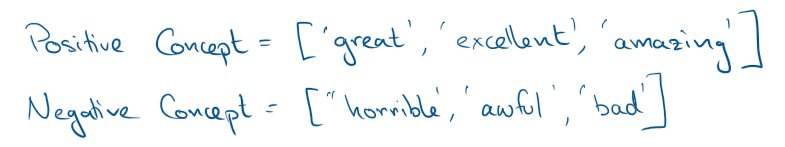

Consider the following tokenized review as our example:

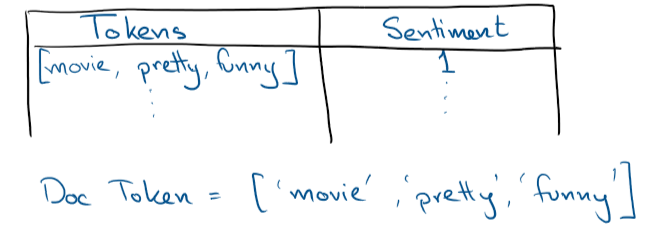

We convert the concept lists and the doc token list to vectors:

Let us look into the positive concept and doc token similarity

<h3><center>Positive Concept (dv1)</center></h3>  <h3><center>                     Doc Token (dv2)</center></h3>

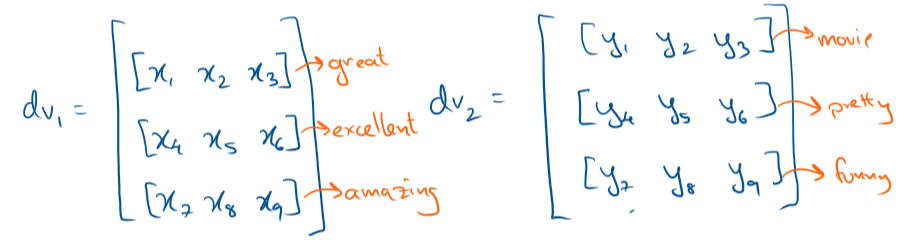

Divide the vectors by their magnitudes to obtain the corresponding unit vectors

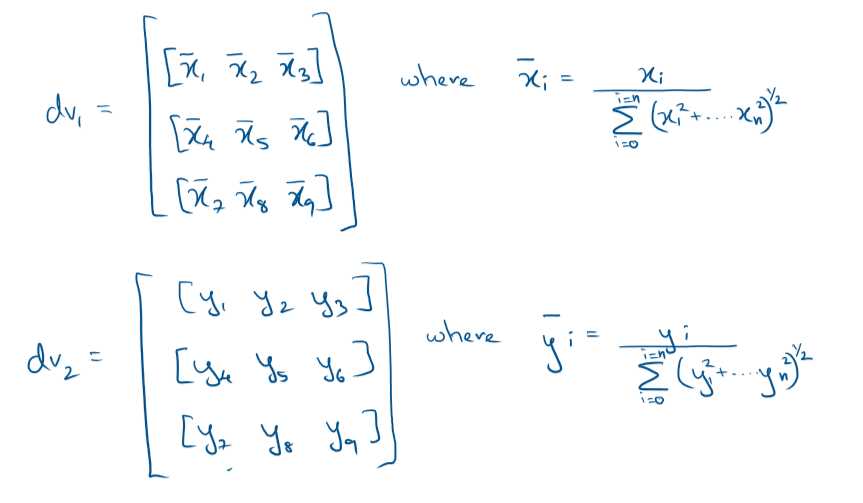

We then obtain the similarity matrix from the dot product between dv1 and transpose of dv2 normal vectors

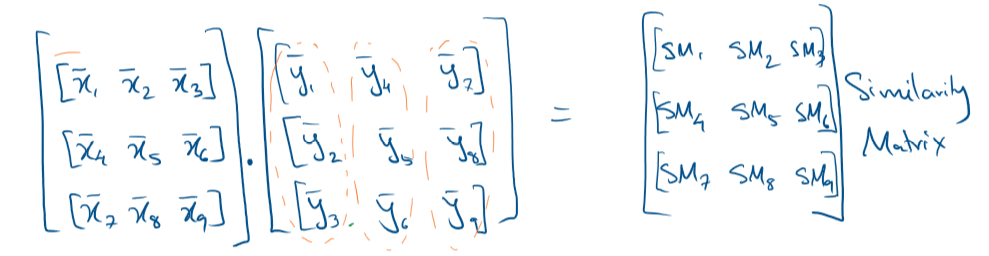

So effectively we are taking dot products of two unit vectors i.e. we are obtaining the cosine similarity between these word vectors and placing them in the similarity matrix

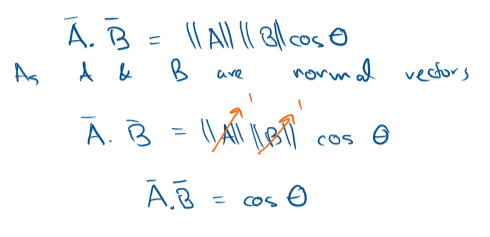

We slice the top n values to obtain the most relevant word similarity scores

Then we calculate the mean of the all values in the matrix to obtain similarity score.

We could just proceed with the similarity score, but there is a certain issue of dependancy.
From my previous implementation of using this function we notice a correlation between the length of the movie review and the psoitive/negative with doc token similarity score.

This is because with longer reviews, there are more words in the doc tokens hence there is just a higher chance of multiple positive and negative words to pop up and get included in the similarity matrix.

A short review might have same strong sentiment but will not have enough words to fill up the vector.

We can see below the correlation between Review length and the sentiment score that arises:

 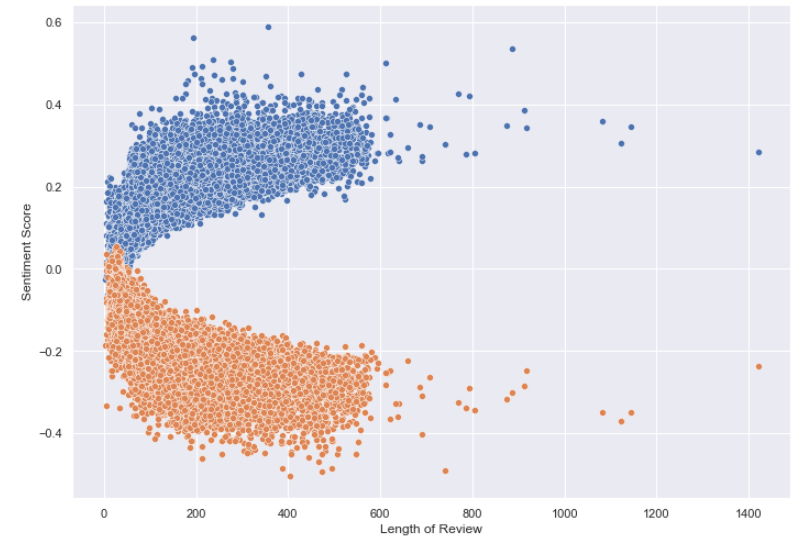  

To counteract this we introduce a penalty function which basically normalizes all the reviews with respect to the length of the review.

After trying out multiple functions, $y = \sqrt[3]{x}$  worked the best

This removes the dependancy as shown below:

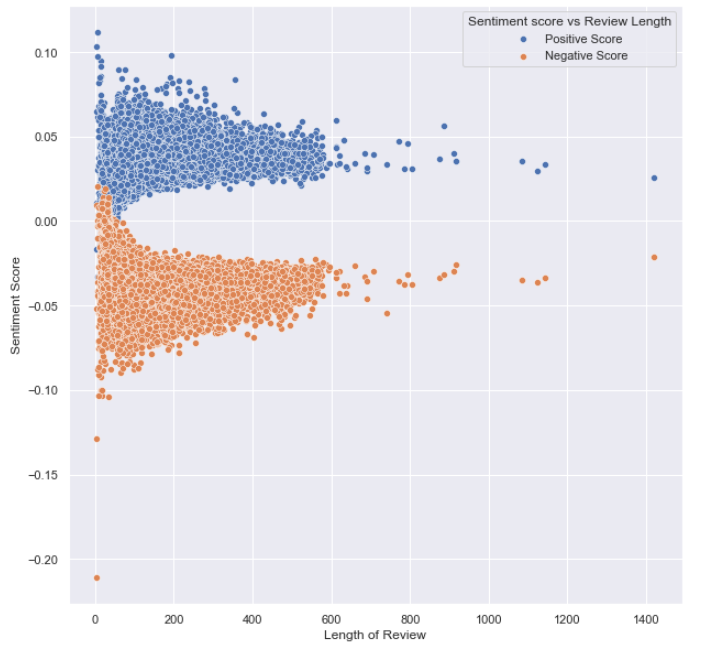

The final overall sentiment is calculated as below:

$ Sentiment Score = Positive Score - Negative Score$

In [43]:
def list_similarity(keyed_vectors, 
                    wordlist1, 
                    wordlist2):
    """ A function to calculate vector similarity between 2 lists of tokens"""
    dv1= np.array([keyed_vectors[word] for word in wordlist1 if word in keyed_vectors])
    dv2= np.array([keyed_vectors[word] for word in wordlist2 if word in keyed_vectors])
    
          
    
    #calculate the vector norms along x direction and then increase the dimension
    #using np.newaxis
    dv1_norm = np.linalg.norm(dv1, axis=1)[:, np.newaxis]
    dv2_norm = np.linalg.norm(dv2, axis=1)[:, np.newaxis] 
    


    #Divide the vector by their sum to get the unit vectors
    dv1 /= dv1_norm
    dv2 /= dv2_norm
    


    return np.dot(dv1, np.transpose(dv2))
    

In [120]:
def calculate_topn_similarity_score(keyed_vectors, 
                          target_tokens, 
                          doc_tokens,
                          topn: int = 10) -> float:
    """ The function calculates the similarity of some concept words to a document, 
    as the average of its similarity with the top_n most similar words in that document. 
    To calculate the similarity score it calculates the similarity of every word in the target_tokens set with all the words in the doc_tokens, 
    and keeps the top_n highest scores for each word and then averages over all the kept scores.
    -----
    Parameters:
    target_tokens List[str] : A list of sentiment or opinion words that indicate negative or positive opinions  
    
    doc_tokens List[str]    : A tokenized document 
    
    keyed_vectors           : A word2vec vocabulary model
    
    topn (int)              : An int that indicates the number of
    most similar vectors used to calculate the similarity score.
    
    Returns:
    vector similarity scores between 2 tokenized list doc_tokens and target_tokens  
    """
    topn = min(topn, round(len(doc_tokens)))
    

    
    target_tokens = [token for token in target_tokens if token in keyed_vectors]

    doc_tokens = [token for token in doc_tokens if token in keyed_vectors]
    

    
    sim_matrix = list_similarity(keyed_vectors=keyed_vectors, 
                                 wordlist1=target_tokens,
                                 wordlist2=doc_tokens)
    

    
    sim_matrix = np.sort(sim_matrix, axis=1)[:, -topn:]
    

     
    similarity_score = np.mean(sim_matrix)
    
    #normalizing score with the cube root of the length of the review tokens
    
    similarity_score_norm = similarity_score/np.cbrt(len(doc_tokens))
    

    
    
    return similarity_score_norm

In [69]:
def topn_semantic_sentiment_analysis(keyed_vectors, 
                                      positive_target_tokens,
                                      negative_target_tokens,
                                      doc_tokens,
                                      topn: int = 10) -> float:
    """
    A function to calculate the semantic sentiment of the text by measuring vector similarity between 
    doc_tokens and a positive_target_tokens (as positive_score) then measuring vector similarity between 
    doc_tokens and a negative_target_tokens (as negative_score), and finally comparing these two scores. 
    
    Parameters:
    keyed_vectors           : A word2vec vocabulary model
    positive_target_tokens  : A list of sentiment or opinion words that indicate positive opinions 
    negative_target_tokens  : A list of sentiment or opinion words that indicate negative opinions  
    doc_tokens              : A tokenized document 
    
    
    Returns:
    positive_score            : vector similarity scores between doc_tokens and positive_target_tokens
    negative_score            : vector similarity scores between doc_tokens and negative_target_tokens
    
    semantic_sentiment_score  : positive_score - negative_score
    semantic_sentiment_polarity       : Overall score: 0 for more negative or 1 for more positive doc
    """
    #positive and negative scores return an array of scores
    
    positive_score = doc_tokens.apply(lambda x: calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=positive_target_tokens, 
                                                                 doc_tokens=x,
                                                                     topn=topn))
                                      
    negative_score = doc_tokens.apply(lambda x: calculate_topn_similarity_score(keyed_vectors=keyed_vectors, 
                                                                 target_tokens=negative_target_tokens, 
                                                                 doc_tokens=x,
                                                                     topn=topn))
                                           
    semantic_sentiment_score = positive_score - negative_score
    

    
    semantic_sentiment_polarity = semantic_sentiment_score.apply(lambda x: 1 if (x > 0) else 0)
                                          
    return positive_score, negative_score, semantic_sentiment_score, semantic_sentiment_polarity

In [121]:
topn_df_scores = topn_semantic_sentiment_analysis (keyed_vectors = keyed_vectors,
                                                   positive_target_tokens = positive_concepts, 
                                                   negative_target_tokens = negative_concepts,
                                                   doc_tokens =  imdb_df_2["Tokens"],
                                                     topn=30)

In [122]:
imdb_df_2['topn_PSS'] = topn_df_scores[0] 
imdb_df_2['topn_NSS'] = topn_df_scores[1] 
imdb_df_2['topn_semantic_sentiment_score'] = topn_df_scores[2] 
imdb_df_2['topn_semantic_sentiment_polarity'] = topn_df_scores[3]

In [123]:
imdb_df_2.head()

,review,sentiment,review_no_stops,Tokens,topn_PSS,topn_NSS,topn_semantic_sentiment_score,topn_semantic_sentiment_polarity,length
0,one of the other reviewers has mentioned that ...,1,one reviewers mentioned watching oz episode yo...,"[one, reviewer, mentioned, watching, oz, episo...",0.026615,0.031696,-0.005081,0,167
1,a wonderful little production the filming tech...,1,wonderful little production filming technique ...,"[wonderful, little, production, filming, techn...",0.048834,0.036988,0.011845,1,84
2,i thought this was a wonderful way to spend ti...,1,thought wonderful way spend time hot summer we...,"[thought, wonderful, way, spend, time, hot, su...",0.039695,0.030056,0.009639,1,85
3,basically theres a family where a little boy j...,0,basically theres family little boy jake thinks...,"[basically, there, family, little, boy, jake, ...",0.020123,0.036665,-0.016541,0,66
4,petter matteis love in the time of money is a ...,1,petter matteis love time money visually stunni...,"[petter, matteis, love, time, money, visually,...",0.041688,0.029299,0.012390,1,125


In [125]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns


def evaluate_model (y_true: pd.Series, 
                              y_pred: pd.Series, 
                              report:bool = False,
                              plot: bool = False)-> float:
    """
    A function to calculate F1, Accuracy, Recall, and Precision Score
    If report: it prints classification_report 
    If plot: it prints Confusion Matrix Heatmap
    """
    if report:
        print(classification_report(y_true, 
                            y_pred,
                            digits=4))
    if plot:
        # figure
        fig, ax = plt.subplots(figsize=(4, 4))
        conf_matrix = pd.crosstab(y_true, 
                           y_pred, 
                           rownames=['Actual'], 
                           colnames=['Predicted'])
        sns.heatmap(conf_matrix, 
                    annot=True, fmt=".0f",
                    cmap='RdYlGn', # use orange/red colour map
                    cbar_kws={'fraction' : 0.04}, # shrink colour bar
                    linewidth=0.3, # space between cells
                   ) 
        plt.title('Confusion Matrix', fontsize=14)
        plt.show()
        
    if not report and not plot:
        print('* Accuracy Score: ', "{:.4%}".format(accuracy_score(y_true, y_pred)))
        print('* F1 Score: ', "{:.4%}".format(f1_score(y_true, y_pred )))
        print('* Recall Score: ', "{:.4%}".format(recall_score(y_true , y_pred )))
        print('* Precision Score: ', "{:.4%}".format(precision_score(y_true , y_pred)))
        

              precision    recall  f1-score   support

           0     0.7452    0.8926    0.8123     25000
           1     0.8662    0.6948    0.7711     25000

    accuracy                         0.7937     50000
   macro avg     0.8057    0.7937    0.7917     50000
weighted avg     0.8057    0.7937    0.7917     50000



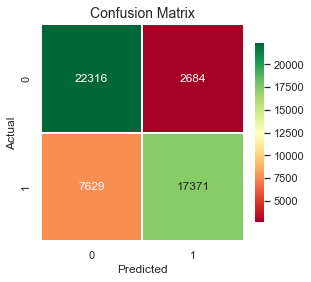

In [126]:
evaluate_model(imdb_df_2["sentiment"], imdb_df_2["topn_semantic_sentiment_polarity"], report=True,plot = True)

In [127]:
evaluate_model(imdb_df_2["sentiment"], imdb_df_2["topn_semantic_sentiment_polarity"])

* Accuracy Score:  79.3740%
* F1 Score:  77.1102%
* Recall Score:  69.4840%
* Precision Score:  86.6168%


In [128]:
# Split x and y

y = imdb_df_2["sentiment"]
X = imdb_df_2["Tokens"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3, stratify = y)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (35000,)
X_test:  (15000,)


In [129]:
#Fit the count vectorizer to the X _train
from sklearn.feature_extraction.text import CountVectorizer



vectorized = CountVectorizer(analyzer = 'word',tokenizer= lambda doc:doc, preprocessor = lambda doc:doc, min_df= 3, token_pattern = None)

#Create Document vectors
vectorized_fit = vectorized.fit(X_train)

X_train_matrix = vectorized_fit.transform(X_train)
X_test_matrix = vectorized_fit.transform(X_test)

print("Size of document vectors:", X_train_matrix.shape[1])


Size of document vectors: 41795


In [130]:
#Train logistic regression
from sklearn.linear_model import LogisticRegressionCV



log_reg_model = LogisticRegressionCV(cv = 5, random_state=42, n_jobs = -1, verbose = 3,max_iter = 300).fit(X_train_matrix, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   41.6s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   42.0s finished


              precision    recall  f1-score   support

           0     0.8964    0.8828    0.8896      7500
           1     0.8846    0.8980    0.8912      7500

    accuracy                         0.8904     15000
   macro avg     0.8905    0.8904    0.8904     15000
weighted avg     0.8905    0.8904    0.8904     15000



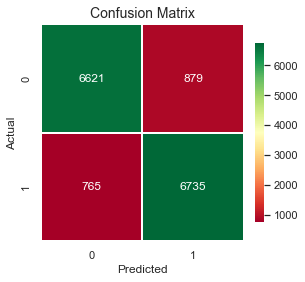

In [131]:
y_predict = log_reg_model.predict(X_test_matrix)

evaluate_model(y_true = y_test, 
               y_pred = y_predict, 
               report=True,
               plot=True)

In [132]:
y_predict = log_reg_model.predict(X_test_matrix)

evaluate_model(y_true = y_test, 
               y_pred = y_predict)

* Accuracy Score:  89.0400%
* F1 Score:  89.1227%
* Recall Score:  89.8000%
* Precision Score:  88.4555%


In [133]:
imdb_df_2["length"]  = imdb_df_2["Tokens"].apply(lambda x : len(x))

In [134]:
sns.set_theme()

In [135]:
imdb_df_2["topn_NSS"] = imdb_df_2["topn_NSS"].apply(lambda x: -x)

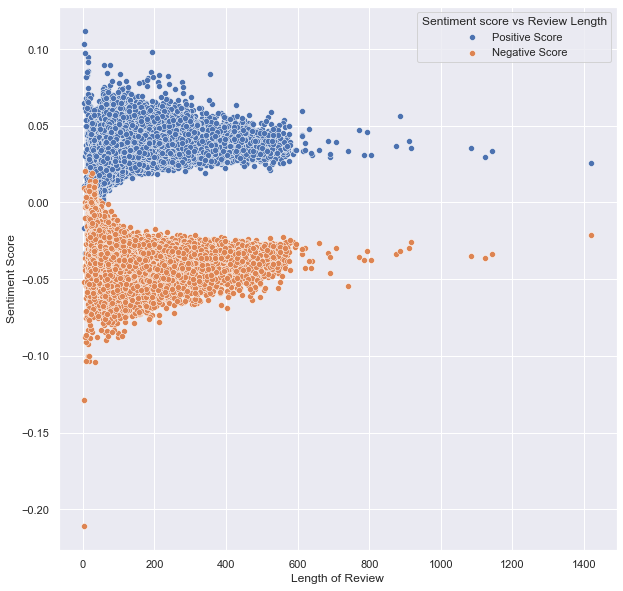

In [141]:
from matplotlib import rcParams

ax = sns.scatterplot(x ="length", y = "topn_PSS", data = imdb_df_2)

sns.scatterplot(x ="length", y = "topn_NSS", data = imdb_df_2)

#g.ax.axline(xy1=(10, 2), slope=.2, color="b", dashes=(5, 2))

# g = (g.set_axis_labels("Sentiment Score", "Length of Review"))

ax.set(xlabel='Length of Review', ylabel='Sentiment Score')

rcParams['figure.figsize'] = 10,10

plt.legend(title = "Sentiment score vs Review Length", labels = ["Positive Score", "Negative Score"], loc = 'upper right')

plt.show(ax)

C:\Users\farhanhasan\Anaconda3\envs\geo_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\farhanhasan\Anaconda3\envs\geo_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


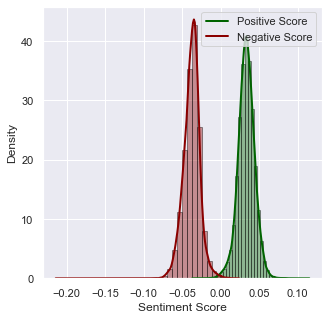

In [143]:
ax = sns.distplot(imdb_df_2['topn_PSS'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

sns.distplot(imdb_df_2['topn_NSS'], hist=True, kde=True, 
             bins=int(180/5), color = 'darkred', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})

ax.set(xlabel='Sentiment Score', ylabel='Density')

rcParams['figure.figsize'] = 5,5

plt.legend(labels = ["Positive Score", "Negative Score"], loc = 'upper right')

# CONCLUSION #

So we can compare the model results below and we can see that our unsupervised model did fairly well given that it was not fed any labelled data.

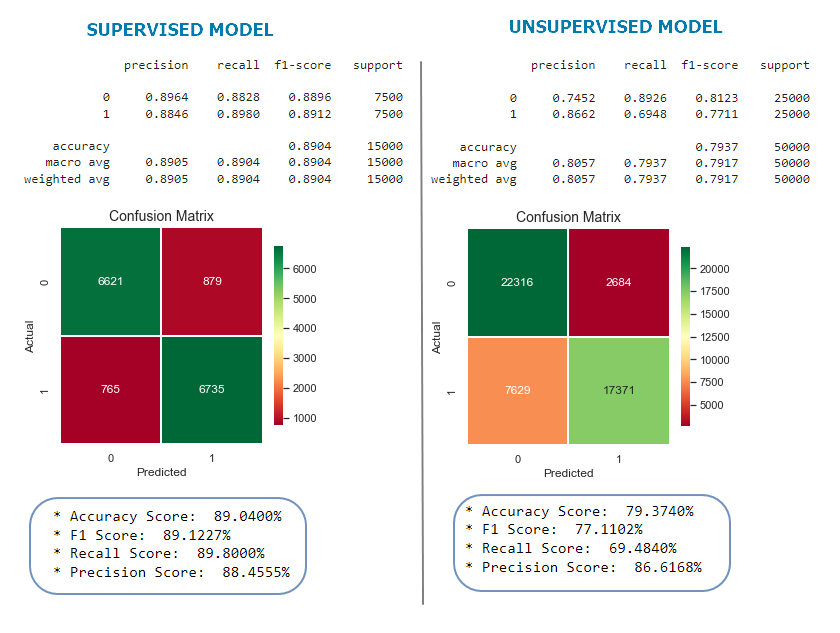